In [11]:
import rioxarray
import pygmt
from pyproj import Proj, Geod
from osgeo import gdal
#gdal.AllRegister()
import sys
sys.path.append('/Users/chanagan/Documents/GitHub/ImageryResources/Functions/')
import TiffTools as tt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.spatial import cKDTree
from scipy import stats

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
projfolder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/'

P = Proj('epsg:32610')
G = Geod(ellps='WGS84')

In [5]:
obs_pts = np.load(projfolder+'/SlipInversion/obs_xyz.npy')


In [6]:
centroids = np.load(projfolder+'/SlipInversion/tricentroids_xyz.npy')

In [7]:
# Bounding polygon +-5000 m from fault max SW and minSE points
coords = []
px,py = P(max(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == max(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,-5000)[0:-1]))
px,py = P(max(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == max(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,5000)[0:-1]))
px,py = P(min(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == min(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,5000)[0:-1]))
px,py = P(min(centroids[:,0]),centroids[:,1][np.where(centroids[:,0] == min(centroids[:,0]))][0],inverse=True)
coords.append(list(G.fwd(px,py,-135,-5000)[0:-1]))
coords.append(coords[0])
coords = np.array(coords)
coords = np.column_stack([P(coords[:,0],coords[:,1])[0],P(coords[:,0],coords[:,1])[1]])
#polygon = Polygon(coords)
geometries = [
    {
        'type': 'Polygon',
        'coordinates': [coords.tolist()]
    }
]

## Save velocity grids

In [8]:
import datetime

In [ ]:
gdal_translate /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_notaligned/ParallelVel.tif /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_notaligned/ParallelVel.pdf 

In [10]:
lidparf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_notaligned/ParallelDisp.tif'
uavparf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/DisplacementRasters/MR_uavlosv.tif'

timediff = (datetime.datetime(2018,2,17) - datetime.datetime(2007,4,1)).days/365.25

lidpar = rioxarray.open_rasterio(lidparf,masked=True)
lidpar.data = lidpar.data/timediff * 100
lidpar = lidpar.rio.clip(geometries)

uavpar = rioxarray.open_rasterio(uavparf)
uavpar = uavpar.rio.reproject('EPSG:32610')
uavpar = uavpar.rio.clip(geometries)

uavpar = uavpar.rio.reproject('EPSG:4326')
lidpar = lidpar.rio.reproject('EPSG:4326')


In [8]:
# Read fault points and demean based on fault points mean (0 at faul is prefered)
fltpts = pd.read_csv('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/GIS/MRMRtrace_unconnected.csv')

# Save velocity tiff
#im = gdal.Open(lidparf)
#data = im.GetRasterBand(1).ReadAsArray()
#mask = (data == -9999)
#data[mask] = np.nan
## calculate velocity, and remove difference from uavsar data 
fltdisp = pygmt.grdtrack(lidpar,points=fltpts[['X','Y']].values)
lidmean = fltdisp[2].mean()
lidpar = lidpar - lidmean
#data = data/timediff*100 - fltdisp[2].mean()
#data[mask] = -9999
#tt.save_geotiff(data,'/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_old/ParallelVel.tif', im.GetGeoTransform(), im.GetProjection(),nodata=-9999)
#data = None

#im = gdal.Open(uavparf)
#data = im.GetRasterBand(1).ReadAsArray()
#mask = (data == -9999)
#data[mask] = np.nan
# calculate velocity, and remove difference from uavsar data 
fltdisp = pygmt.grdtrack(uavpar,points=fltpts[['X','Y']].values)
uavmean = fltdisp[2].mean()
uavpar = uavpar - uavmean
#data -= fltdisp[2].mean()
#data[mask] = -9999
#tt.save_geotiff(data,'/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/DisplacementRasters/MR_uavlosv_demeaned.tif', im.GetGeoTransform(), im.GetProjection(),nodata=-9999)
data = None

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNING]: Some input points were outside the grid domain(s).
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNING]: Some input points were outside the grid domain(s).


## Sample from velocity grids

In [8]:
lidparf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/MEC_old/ParallelVel.tif'
uavparf = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/DisplacementRasters/MR_uavlosv_demeaned.tif'


lidpar = rioxarray.open_rasterio(lidparf,masked=True)
lidpar = lidpar.rio.clip(geometries)

uavpar = rioxarray.open_rasterio(uavparf)
uavpar = uavpar.rio.reproject('EPSG:32610')
uavpar = uavpar.rio.clip(geometries)

uavpar = uavpar.rio.reproject('EPSG:4326')
lidpar = lidpar.rio.reproject('EPSG:4326')

In [9]:
# Observation points distance to nearest neighbor
tree = cKDTree(obs_pts)  # Efficient distance calculation
distances, _ = tree.query(obs_pts,k=2)
distances = distances[:,-1] # next closest point in list

In [10]:
spacing = 0.5
aggregation_levels = [2, 4, 8, 16]  # Coarsening factors (multiples of spacing)

resampled_grids = {}
for level in aggregation_levels:
    factor = int(level * spacing)  # Ensure integer spacing for coarsen
    lidpar_resampled = lidpar.coarsen(x=factor, y=factor, boundary="pad").median()
    uavpar_resampled = uavpar
    resampled_grids[factor] = (lidpar_resampled, uavpar_resampled)



In [11]:
# Precompute search distances and determine the corresponding aggregation level
max_search = 30
search_radii = np.minimum(distances / 2, max_search)

factor = []
for rad in search_radii:
    res = []
    for level in aggregation_levels:
        res.append(np.absolute(rad-int(level * spacing)))
    factor.append(aggregation_levels[(np.array(res)).argmin()]/2)


In [ ]:
lidpar

In [ ]:
dispdf = pd.DataFrame()
for level in np.unique(factor):
    pts = obs_pts[np.array(factor) == level][:,(0,1)]
    lons, lats = P(pts[:,0],pts[:,1],inverse=True)
    uav = resampled_grids[int(level)][0] 
    lid = resampled_grids[int(level)][1] 
    displid = pygmt.grdtrack(lid, np.column_stack([lons,lats]))
    dispuav = pygmt.grdtrack(uav, np.column_stack([lons,lats]))
    dispdf = pd.concat([dispdf,displid,dispuav]).dropna()
    print(len(dispdf))

# Filter >3<
dispdf.drop(dispdf[np.absolute(dispdf[2])>4][2].index,inplace=True)
dispdf = dispdf.groupby([0, 1], as_index=False).agg({2: 'mean'})
#dispdf.to_csv('/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/CSAF_Lidar/SlipInversion/MergedObsDispAggregate.csv',index=False)

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float32 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,


11399


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float32 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,


36733


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float32 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,


78964


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float32 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,


98137


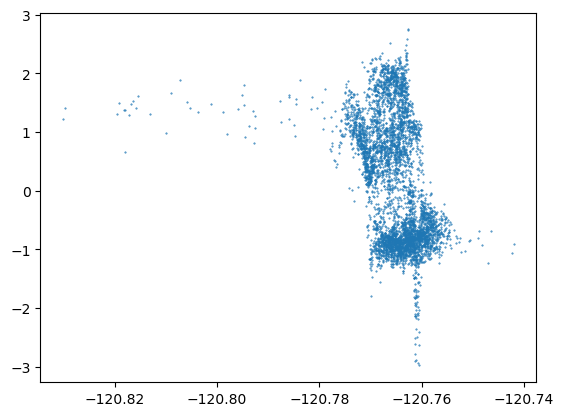

In [46]:
plt.scatter(dispdf[((dispdf[1]>36.181390) & (dispdf[1]<36.192390))][0],dispdf[((dispdf[1]>36.181390) & (dispdf[1]<36.192390))][2],s=0.2)

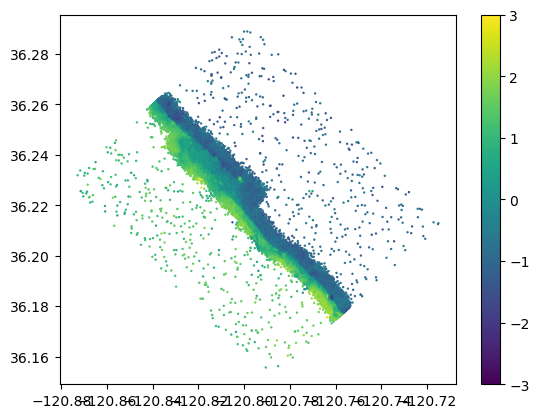

In [48]:
plt.scatter(dispdf[0],dispdf[1],c=dispdf[2],s=0.5,vmin=-3,vmax=3)
plt.colorbar()

# OLD BEYOND HERE

In [ ]:
for level1, level2 in zip(aggregation_levels[:-1],aggregation_levels[1:]):
    idx = np.where(((distances >= level1) & (distances < level2)))
    

In [47]:
# Resample rasters to coarser grids for large search distances
# Adjust the factor to ensure it's an integer
aggregation_levels = [2, 4, 8, 16]  # Coarsening factors (multiples of spacing)
resampled_grids = {}
for level in aggregation_levels:
    factor = int(level * spacing)  # Ensure integer spacing for coarsen
    lidpar_resampled = lidpar.coarsen(x=factor, y=factor, boundary="pad").mean()
    uavpar_resampled = uavpar.coarsen(x=factor, y=factor, boundary="pad").mean()
    resampled_grids[factor] = (lidpar_resampled, uavpar_resampled)

# Precompute search distances
search_radii = np.minimum(distances / 2, max_search)

# Group points by search radius to batch process
displacement = np.empty(len(obs_pts))
displacement[:] = np.nan  # Default to NaN
unique_radii = np.unique(search_radii)
print(len(unique_radii))

for radius in unique_radii:
    print(f"Processing radius {radius}...")
    factor = next((f for f in sorted(resampled_grids.keys()) if f >= radius), spacing)
    lidpar_resampled, uavpar_resampled = resampled_grids[factor]
    
    # Identify points in the current batch
    batch_indices = np.where(search_radii == radius)[0]
    batch_points = obs_pts[batch_indices]
    
    # Create grid points for the current batch
    for i, point in zip(batch_indices, batch_points):
        x_range = np.arange(point[0] - radius, point[0] + radius, spacing)
        y_range = np.arange(point[1] - radius, point[1] + radius, spacing)
        grid_points = np.column_stack(np.array(np.meshgrid(x_range, y_range, indexing="ij")).reshape(2, -1))
        
        # Query and combine data from resampled grids
        lid_values = pygmt.grdtrack(lidpar_resampled, grid_points)
        uav_values = pygmt.grdtrack(uavpar_resampled, grid_points)
        if len(lid_values) > 0 and len(uav_values) > 0:
            combined_values = pd.concat([lid_values.iloc[:, -1], uav_values.iloc[:, -1]]).dropna()
        elif len(lid_values) > 0 and len(uav_values) == 0:
            combined_values = lid_values.iloc[:, -1].dropna()
        elif len(uav_values) > 0 and len(lid_values) == 0:
            combined_values = uav_values.iloc[:, -1].dropna()
        else:
            combined_values = pd.DataFrame()
        # Compute trimmed mean
        displacement[i] = trim_mean(combined_values, 0.32) if not combined_values.empty else np.nan


1589
Processing radius 0.25...


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float32 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNING]: Some input points were outside the grid domain(s).
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: Runtime

KeyboardInterrupt: 

In [19]:
spacing = 0.5
displacement = []
for i in range(0,len(obs_pts)):
    print(i/len(obs_pts)*100,'%')
    if distances < 30:
        search = distances[i]/2 # radius of grid to search and average data
    else:
        search = 30
    pts = np.meshgrid(np.arange(obs_pts[i,0]-search,obs_pts[i,0]+search,spacing),
                        np.arange(obs_pts[i,1]-search,obs_pts[i,1]+search,spacing))
    res = pygmt.grdtrack(lidpar,np.column_stack([pts[0].flatten(),pts[1].flatten()]))
    res = pd.concat([res,pygmt.grdtrack(uavpar,np.column_stack([pts[0].flatten(),pts[1].flatten()]))])
    if len(res) >=1:
        displacement.append(stats.trim_mean(res.iloc[:,-1],0.32)) # trimmed mean of 1-sigma percentage of data
    else:
        displacement.append(np.nan)

0.0 %


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [2]:
distances

NameError: name 'distances' is not defined

In [ ]:
plt.scatter(c=uavpar.data[0].flatten())
plt.scatter((obs_pts[:,0]-uavpar.x.min().data)/11,-1*(obs_pts[:,1]-uavpar.y.max().data)/11,c=displacement)


33672

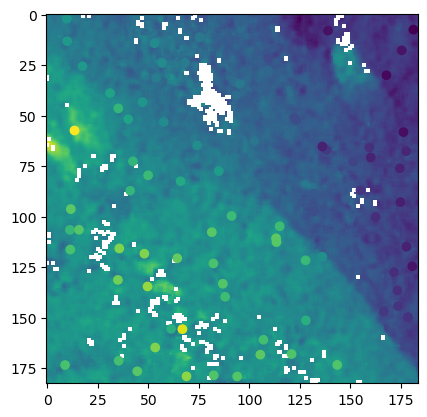

In [ ]:
plt.imshow(uavpar.data[0])
plt.scatter((obs_pts[:,0]-uavpar.x.min().data)/11,-1*(obs_pts[:,1]-uavpar.y.max().data)/11,c=displacement)


In [ ]:
stats.trim_mean(res.iloc[:,-1],0.32) # cut to mean of 1 std

np.float64(1.3015054670824686)

3600